In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image

class PairedGenerator(nn.Module):
    def __init__(self):
        super(PairedGenerator, self).__init__()
        # First convolution now accepts 6 channels
        self.initial = nn.Sequential(
            nn.Conv2d(6, 64, kernel_size=7, padding=3, padding_mode='reflect'),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        )

        # Downsampling blocks
        self.down_blocks = nn.Sequential(
            self._down_block(64, 128),
            self._down_block(128, 256)
        )

        # Residual blocks
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(256) for _ in range(9)]
        )

        # Upsampling blocks
        self.up_blocks = nn.Sequential(
            self._up_block(256, 128),
            self._up_block(128, 64)
        )

        # Output convolution
        self.output = nn.Sequential(
            nn.Conv2d(64, 3, kernel_size=7, padding=3, padding_mode='reflect'),
            nn.Tanh()
        )

    def _down_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, stride=2, padding=1),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def _up_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.down_blocks(x)
        x = self.res_blocks(x)
        x = self.up_blocks(x)
        return self.output(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1, padding_mode='reflect'),
            nn.InstanceNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, 3, padding=1, padding_mode='reflect'),
            nn.InstanceNorm2d(channels)
        )

    def forward(self, x):
        return x + self.block(x)

class PatchDiscriminator(nn.Module):
    def __init__(self, input_channels=3):
        super(PatchDiscriminator, self).__init__()
        self.model = nn.Sequential(
            # First layer (no normalization)
            nn.Conv2d(input_channels, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            # Subsequent layers with normalization
            self._discriminator_block(64, 128),
            self._discriminator_block(128, 256),
            self._discriminator_block(256, 512),

            # Final layer to output a prediction
            nn.Conv2d(512, 1, 4, padding=1)
        )

    def _discriminator_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, stride=2, padding=1),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x):
        return self.model(x)

class PairedStyleDataset(Dataset):
    def __init__(self, shirt_dir, art_dir, transform=None):
        self.shirt_files = sorted(os.listdir(shirt_dir))
        self.art_files = sorted(os.listdir(art_dir))

        # equal number of images and shirts
        min_len = min(len(self.shirt_files), len(self.art_files))
        self.shirt_files = self.shirt_files[:min_len]
        self.art_files = self.art_files[:min_len]

        self.shirt_dir = shirt_dir
        self.art_dir = art_dir
        self.transform = transform

    def __len__(self):
        return len(self.shirt_files)

    def __getitem__(self, idx):
        # Load shirt and art images
        shirt_path = os.path.join(self.shirt_dir, self.shirt_files[idx])
        art_path = os.path.join(self.art_dir, self.art_files[idx])

        shirt_img = Image.open(shirt_path).convert('RGB')
        art_img = Image.open(art_path).convert('RGB')

        if self.transform:
            shirt_img = self.transform(shirt_img)
            art_img = self.transform(art_img)

        # Concatenate images
        combined_input = torch.cat([shirt_img, art_img], dim=0)

        return {
            'input': combined_input,  # 6-channel tensor
            'target': shirt_img  # Original shirt image as target
        }

def train_paired_stylegan(shirt_dir, art_dir, num_epochs=200, batch_size=4):
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Transformations
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))#-1,1
    ])

    ## Dataset and DataLoader
    dataset = PairedStyleDataset(shirt_dir, art_dir, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Initialize models
    generator = PairedGenerator().to(device)
    discriminator = PatchDiscriminator(input_channels=3).to(device)

    # Loss functions
    adversarial_loss = nn.MSELoss()
    reconstruction_loss = nn.L1Loss()

    # Optimizers
    g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    # Training loop
    for epoch in range(num_epochs):
        for batch_idx, batch in enumerate(dataloader):
            # Move data to device
            combined_input = batch['input'].to(device)
            real_shirt = batch['target'].to(device)

            # Generate styled shirt
            styled_shirt = generator(combined_input)

            # Discriminator Training
            d_optimizer.zero_grad()

            # Real prediction
            real_pred = discriminator(real_shirt)
            real_labels = torch.ones_like(real_pred)
            real_loss = adversarial_loss(real_pred, real_labels)

            # Fake prediction -> shirt
            fake_pred = discriminator(styled_shirt.detach())
            fake_labels = torch.zeros_like(fake_pred)
            fake_loss = adversarial_loss(fake_pred, fake_labels)

            # Total discriminator loss
            d_loss = (real_loss + fake_loss) * 0.5
            d_loss.backward()
            d_optimizer.step()

            # Generator Training
            g_optimizer.zero_grad()

            # Adversarial loss
            fake_pred = discriminator(styled_shirt)
            g_adv_loss = adversarial_loss(fake_pred, real_labels)

            # Reconstruction loss
            reconstruction = generator(torch.cat([styled_shirt, real_shirt], dim=1))
            recon_loss = reconstruction_loss(reconstruction, real_shirt)

            # Total generator loss
            g_loss = g_adv_loss + recon_loss * 10  
            g_loss.backward()
            g_optimizer.step()

            # Logging
            if batch_idx % 50 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], '
                      f'Batch [{batch_idx}/{len(dataloader)}], '
                      f'D Loss: {d_loss.item():.4f}, '
                      f'G Loss: {g_loss.item():.4f}')

        if (epoch+1)%40 == 0:
            #model checkpoints per 40 epoch
            torch.save({
                'generator_state_dict': generator.state_dict(),
                'discriminator_state_dict': discriminator.state_dict(),
                'g_optimizer_state_dict': g_optimizer.state_dict(),
                'd_optimizer_state_dict': d_optimizer.state_dict(),
                'epoch': epoch
            }, f'checkpoint_epoch_{epoch+1}.pth')

# Inference function
def apply_style_transfer(shirt_path, art_path, generator, transform):
    shirt_img = Image.open(shirt_path).convert('RGB')
    art_img = Image.open(art_path).convert('RGB')

    #apply transforms
    shirt_tensor = transform(shirt_img).unsqueeze(0)
    art_tensor = transform(art_img).unsqueeze(0)

    # Concatenate images
    combined_input = torch.cat([shirt_tensor, art_tensor], dim=1)


    with torch.no_grad():
        styled_shirt = generator(combined_input)

    # Convert to image
    to_pil = transforms.ToPILImage()
    styled_shirt_img = to_pil(styled_shirt.squeeze(0))

    return styled_shirt_img



In [ ]:
# Example usage
if __name__ == "__main__":
    # Training
    art_dir = 'Desktop/gans-dataset/art-dataset/art_dataset'
    shirt_dir = 'Desktop/gans-dataset/shirt-dataset/shirt_dataset'
    train_paired_stylegan(shirt_dir, art_dir)



Epoch [1/200], Batch [0/156], D Loss: 0.4753, G Loss: 4.0594
Epoch [1/200], Batch [50/156], D Loss: 0.1975, G Loss: 2.4052
Epoch [1/200], Batch [100/156], D Loss: 0.1757, G Loss: 2.3671
Epoch [1/200], Batch [150/156], D Loss: 0.1548, G Loss: 2.4631
Epoch [2/200], Batch [0/156], D Loss: 0.1796, G Loss: 2.4037
Epoch [2/200], Batch [50/156], D Loss: 0.2445, G Loss: 2.0426
Epoch [2/200], Batch [100/156], D Loss: 0.1865, G Loss: 2.5911
Epoch [2/200], Batch [150/156], D Loss: 0.2479, G Loss: 1.9542
Epoch [3/200], Batch [0/156], D Loss: 0.1294, G Loss: 2.2998
Epoch [3/200], Batch [50/156], D Loss: 0.2082, G Loss: 2.4332
Epoch [3/200], Batch [100/156], D Loss: 0.1207, G Loss: 2.3015
Epoch [3/200], Batch [150/156], D Loss: 0.2338, G Loss: 2.1775
Epoch [4/200], Batch [0/156], D Loss: 0.2987, G Loss: 2.2603
Epoch [4/200], Batch [50/156], D Loss: 0.1078, G Loss: 3.0212
Epoch [4/200], Batch [100/156], D Loss: 0.1123, G Loss: 1.7261
Epoch [4/200], Batch [150/156], D Loss: 0.2433, G Loss: 2.6814
Epoc

In [ ]:
#Inference
generator = PairedGenerator()
generator.load_state_dict(torch.load('checkpoint_epoch_200.pth')['generator_state_dict'])
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
styled_shirt = apply_style_transfer('Desktop/s3.jpg', 'Desktop/a2.jpg', generator, transform)
styled_shirt.save('Desktop/styled_shirt.jpg')

/tmp/ipykernel_9714/3058161316.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('checkpoint_epoch_200.pth')['generator_state_dict'])


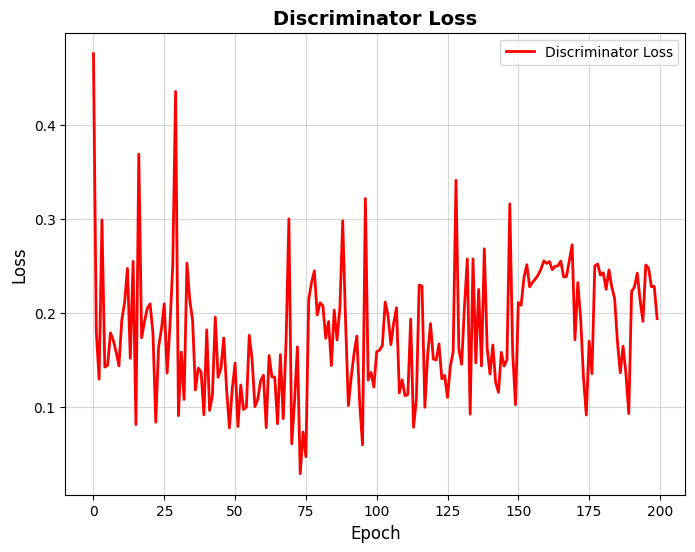

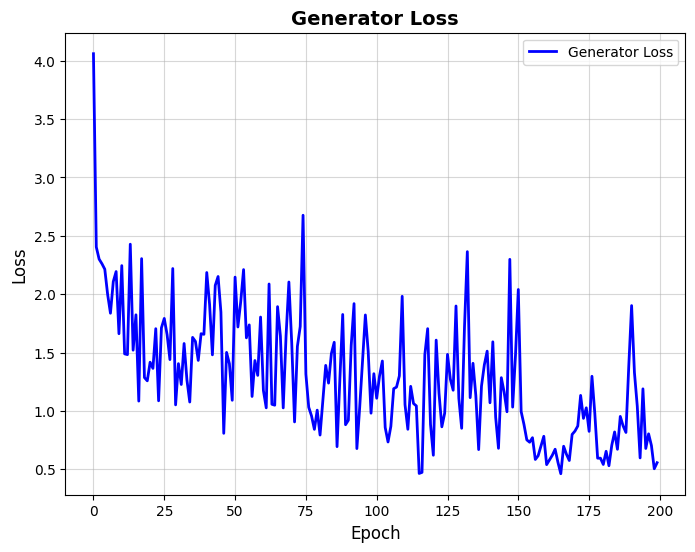

Discriminator Loss Statistics:
Mean: 0.1777
Std Dev: 0.0666
Min: 0.0289
Max: 0.4753

Generator Loss Statistics:
Mean: 1.2933
Std Dev: 0.5404
Min: 0.4616
Max: 4.0594


In [19]:
import matplotlib.pyplot as plt
import numpy as np

def extract_losses(filename):
    d_losses, g_losses = [], []
    
    with open(filename, 'r') as file:
        lines = file.readlines()
        
    for line in lines[::4]:  # Every 4th line is all epochs
        parts = line.split(', ')
        d_loss = float(parts[2].split(': ')[1])
        g_loss = float(parts[3].split(': ')[1].strip())
        
        d_losses.append(d_loss)
        g_losses.append(g_loss)
    
    return d_losses, g_losses


filename = 'res.txt'
d_losses, g_losses = extract_losses(filename)

# Plot 1: Discriminator Loss
plt.figure(figsize=(8, 6))
plt.plot(d_losses, color='red', label='Discriminator Loss', linewidth=2)
plt.title('Discriminator Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(alpha=0.5)
plt.legend(fontsize=10)
plt.show()

# Plot 2: Generator Loss
plt.figure(figsize=(8, 6))
plt.plot(g_losses, color='blue', label='Generator Loss', linewidth=2)
plt.title('Generator Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(alpha=0.5)
plt.legend(fontsize=10)
plt.show()

# Statistical Analysis
print("Discriminator Loss Statistics:")
print(f"Mean: {np.mean(d_losses):.4f}")
print(f"Std Dev: {np.std(d_losses):.4f}")
print(f"Min: {np.min(d_losses):.4f}")
print(f"Max: {np.max(d_losses):.4f}")

print("\nGenerator Loss Statistics:")
print(f"Mean: {np.mean(g_losses):.4f}")
print(f"Std Dev: {np.std(g_losses):.4f}")
print(f"Min: {np.min(g_losses):.4f}")
print(f"Max: {np.max(g_losses):.4f}")